# 📘 Forecasting Migration Flows — **Notebook 03: Feature Engineering and Modeling**

| **Author** | Golib Sanaev |
|-------------|--------------|
| **Project** | Forecasting Migration Flows with Machine Learning |
| **Created** | 2025-09-23 |
| **Last Updated** | 2025-10-14 |

---

### 🎯 Purpose

Develop a **feature-engineered, time-aware modeling pipeline** to forecast **net migration (per 1,000 people)**.  

This notebook introduces interpretable engineered variables and interaction terms, builds a clean modeling matrix, and compares baseline and nonlinear models prior to SHAP-based interpretation in the next stage.

**Links**  
- **Input:** `countries_clean.csv` (from **[Notebook 02: Exploratory Data Analysis (EDA)](02-exploratory-data-analysis.html)**)  
- **Output:** trained models (`random_forest_model.pkl`, `X_columns.pkl`) for use in  
   **[Notebook 04: Model Interpretation and Scenario Analysis](04-model-interpretation-scenario-analysis.html)** and  
   **[Notebook 05: Forecasting and Validation](05-forecasting-validation.html)**  

---

<a id="top"></a>
## 📑 Table of Contents
- [⚙️ 1. Setup and Load Clean Data](#⚙️-1.-Setup-and-Load-Clean-Data)  
- [🧩 2. Target and Feature Engineering](#🧩-2.-Target-and-Feature-Engineering)  
- [🧱 3. Feature Matrix Construction](#🧱-3.-Feature-Matrix-Construction)  
- [⏱️ 4. Time-Aware Train / Validation Split](#time-aware-train-validation-split)  
- [📏 5. Baselines and Scaling](#📏-5.-Baselines-and-Scaling)  
- [🤖 6. Models — Linear Regression and Random Forest](#models-linear-and-random-forest)  
- [🎯 7. Evaluation](#🎯-7.-Evaluation)  
- [🌲 8. Feature Importance (Random Forest)](#feature-importance)  
- [🧮 9. Error Slices (by Region / Income Group)](#error-slices)  
- [💾 10. Save Artifacts](#💾-10.-Save-Artifacts)  
- [🧾 11. Key Insights Summary](#🧾-11.-Key-Insights-Summary)


---

## ⚙️ 1. Setup and Load Clean Data

Load the cleaned dataset produced in **[Notebook 02: Exploratory Data Analysis (EDA)](02-exploratory-data-analysis.html)**, configure the working environment, and verify that all required columns for feature engineering are available.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [1]:
# === Setup and Load Clean Data ===

# --- Imports ---
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

# --- Visualization Settings ---
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white"
})

# --- Data Path and Loading ---
DATA_DIR = Path("../data/processed")
DATA_FILE = DATA_DIR / "countries_clean.csv"

df_country = pd.read_csv(DATA_FILE)
print(f"[INFO] Loaded dataset: {DATA_FILE.name}")
print(f"[INFO] Shape: {df_country.shape}")

# --- Preview ---
df_country.head()

[INFO] Loaded dataset: countries_clean.csv
[INFO] Shape: (5712, 21)


,Country Name,Country Code,year,pop_density,mobile_subs,exports_gdp,imports_gdp,gdp_growth,gdp_per_capita,under5_mortality,...,adol_fertility,life_expectancy,fertility_rate,pop_growth,population,urban_pop_growth,hdi,Region,IncomeGroup,net_migration_per_1000
0,Afghanistan,AFG,1990,18.468424,0.0,16.852788,50.731877,2.685773,417.647283,180.7,...,139.376,45.118,7.576,1.434588,12045660.0,1.855712,0.285,Middle East & North Africa,Low income,-38.083177
1,Afghanistan,AFG,1991,18.764667,0.0,16.852788,50.731877,2.685773,417.647283,174.4,...,145.383,45.521,7.631,1.591326,12238879.0,2.010729,0.291,Middle East & North Africa,Low income,2.678513
2,Afghanistan,AFG,1992,20.359343,0.0,16.852788,50.731877,2.685773,417.647283,168.5,...,147.499,46.569,7.703,8.156419,13278974.0,8.574058,0.301,Middle East & North Africa,Low income,90.167283
3,Afghanistan,AFG,1993,22.910893,0.0,16.852788,50.731877,2.685773,417.647283,163.0,...,149.461,51.021,7.761,11.807259,14943172.0,12.223160,0.311,Middle East & North Africa,Low income,76.937079
4,Afghanistan,AFG,1994,24.915741,0.0,16.852788,50.731877,2.685773,417.647283,157.7,...,156.835,50.969,7.767,8.388730,16250794.0,8.807544,0.305,Middle East & North Africa,Low income,19.396345


## 🧩 2. Target and Feature Engineering

Derive key target and contextual variables used for model training.  
Transformations emphasize **economic** and **demographic interpretability** while avoiding target leakage.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

### Engineered and Derived Variables

| Variable | Description |
|-----------|-------------|
| **net_migration_per_1000_capped** | Migration per 1,000 population, winsorized (±50) — target variable |
| **is_crisis_lag1** | Lagged indicator of migration crisis ( \|net_migration_per_1000\| > 50) |
| **urbanization_rate_stable** | Ratio = urban_pop_growth / pop_growth (clipped to ±5) |
| **trade_openness_ratio** | Ratio = exports_gdp / imports_gdp (bounded 0.2–5) |
| **gdp_growth_x_IncomeGroup** | GDP growth × income tier interaction |
| **pop_growth_x_IncomeGroup** | Population growth × income tier interaction |

**Note:** Continuous × continuous interactions (e.g., GDP × urbanization, trade × HDI)  
and region-based interactions are intentionally omitted to preserve interpretability and reduce multicollinearity.

### 🔍 Correlation Context from Notebook 02

Feature construction is guided by prior correlation analysis.  
The heatmap below (from **Notebook 02: Exploratory Data Analysis (EDA)**) highlights clusters of strongly correlated variables, motivating the creation of ratio-based and interaction features.

![Correlation Heatmap from Notebook 02](https://raw.githubusercontent.com/gsanaev/forecasting-migration-flows-ml/main/docs/correlation_heatmap_country_level.png)

In [2]:
# === Target and Feature Engineering ===

# --- Create Working Copy ---
df = df_country.copy()

# --- Derived Variables ---

# Target: Net migration per 1,000 people (capped ±50)
if "net_migration_per_1000_capped" not in df.columns:
    if "net_migration_per_1000" in df.columns:
        df["net_migration_per_1000_capped"] = df["net_migration_per_1000"].clip(-50, 50)
    else:
        df["net_migration_per_1000_capped"] = (df["net_migration"] / df["population"]) * 1000
        df["net_migration_per_1000_capped"] = df["net_migration_per_1000_capped"].clip(-50, 50)

# --- Crisis Flag and Lagged Indicator ---
CAP = 50
# Use the *original*, uncapped migration values if available
if "net_migration_per_1000" in df.columns:
    df["is_crisis"] = (df["net_migration_per_1000"].abs() > CAP).astype(int)
else:
    # fallback if only capped values exist (unlikely)
    df["is_crisis"] = (df["net_migration_per_1000_capped"].abs() >= CAP).astype(int)

df = df.sort_values(["Country Name", "year"]).reset_index(drop=True)
df["is_crisis_lag1"] = (
    df.groupby("Country Name")["is_crisis"].shift(1).fillna(0).astype(int)
)

# --- Urbanization Ratio (Stable) ---
eps = 1e-9
ratio = df["urban_pop_growth"] / df["pop_growth"].replace(0, np.nan)
ratio = ratio.replace([np.inf, -np.inf], np.nan)
df["urbanization_rate_stable"] = ratio.clip(lower=-5, upper=5).fillna(1.0)

# --- Trade Openness Ratio ---
trade_ratio = df["exports_gdp"] / df["imports_gdp"].replace(0, np.nan)
trade_ratio = trade_ratio.replace([np.inf, -np.inf], np.nan)
df["trade_openness_ratio"] = trade_ratio.clip(lower=0.2, upper=5).fillna(1.0)

# --- Interaction Terms (IncomeGroup Only) ---

# GDP growth × Income Group
if "IncomeGroup" in df.columns:
    income_dummies = pd.get_dummies(df["IncomeGroup"], drop_first=True, prefix="IncomeGroup")
    for col in income_dummies.columns:
        inter_name = f"gdp_growth_x_{col.split('_')[-1]}"
        df[inter_name] = df["gdp_growth"] * income_dummies[col]

# Population growth × Income Group
if "IncomeGroup" in df.columns:
    income_dummies = pd.get_dummies(df["IncomeGroup"], drop_first=True, prefix="IncomeGroup")
    for col in income_dummies.columns:
        inter_name = f"pop_growth_x_{col.split('_')[-1]}"
        df[inter_name] = df["pop_growth"] * income_dummies[col]

# --- Metadata and Diagnostics ---
if "Region" not in df.columns:
    df["Region"] = "Unknown"
if "IncomeGroup" not in df.columns:
    df["IncomeGroup"] = "Unknown"

print("[INFO] Added population growth interaction terms:",
      [c for c in df.columns if c.startswith("pop_growth_x_")])
print("[INFO] Derived variables created:",
      ["net_migration_per_1000_capped", "is_crisis_lag1",
       "urbanization_rate_stable", "trade_openness_ratio"])

[INFO] Added population growth interaction terms: ['pop_growth_x_Low income', 'pop_growth_x_Lower middle income', 'pop_growth_x_Upper middle income']
[INFO] Derived variables created: ['net_migration_per_1000_capped', 'is_crisis_lag1', 'urbanization_rate_stable', 'trade_openness_ratio']


## 🧱 3. Feature Matrix Construction

Assemble a consistent **feature matrix** combining:  
- Structural numeric indicators  
- One-hot-encoded categorical variables (`Region`, `IncomeGroup`)  
- Income-tier interaction terms for growth and population  

Migration-related variables are **explicitly excluded** to prevent data leakage.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [3]:
# === Feature Matrix Construction ===

# --- Define Base Numeric Features ---
base_numeric = [
    "gdp_growth", "gdp_per_capita", "unemployment",
    "trade_openness_ratio", "adol_fertility", "hdi",
    "urbanization_rate_stable", "pop_growth",
    "is_crisis_lag1", "year"
]
base_numeric = [c for c in base_numeric if c in df.columns]

# --- Define Categorical Columns ---
cat_cols = [c for c in ["Region", "IncomeGroup"] if c in df.columns]

# --- One-Hot Encode Categorical Features (drop_first) ---
df_model = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- Ensure Proper 'country' Identifier ---
if "Country Name" in df.columns:
    df_model["country"] = df["Country Name"].astype(str).str.strip()
elif "country" in df.columns:
    df_model["country"] = df["country"].astype(str).str.strip()
else:
    raise ValueError("[ERROR] No country column found — expected 'Country Name' or 'country'.")

# --- Include Interaction Terms (IncomeGroup-based Only) ---
X_cols = base_numeric + [
    c for c in df_model.columns
    if c.startswith(("Region_", "IncomeGroup_", "gdp_growth_x_", "pop_growth_x_"))
]

# --- Leakage Guard: Remove Migration-Related Variables ---
LEAK_PREFIXES = ("net_migration",)
LEAK_EXACT = {"net_migration", "net_migration_per_1000", "net_migration_per_1000_capped"}
X_cols = [
    c for c in X_cols
    if c not in LEAK_EXACT and not any(c.startswith(p) for p in LEAK_PREFIXES)
]

# --- Define Target Variable ---
y_col = "net_migration_per_1000_capped"

# --- Summary ---
print(f"[INFO] Total features selected: {len(X_cols)}")
print(f"[INFO] Example features: {sorted(X_cols)[:25]} ...")
print(f"[INFO] Target variable: {y_col}")

[INFO] Total features selected: 25
[INFO] Example features: ['IncomeGroup_Low income', 'IncomeGroup_Lower middle income', 'IncomeGroup_Upper middle income', 'Region_Europe & Central Asia', 'Region_Latin America & Caribbean', 'Region_Middle East & North Africa', 'Region_North America', 'Region_South Asia', 'Region_Sub-Saharan Africa', 'adol_fertility', 'gdp_growth', 'gdp_growth_x_Low income', 'gdp_growth_x_Lower middle income', 'gdp_growth_x_Upper middle income', 'gdp_per_capita', 'hdi', 'is_crisis_lag1', 'pop_growth', 'pop_growth_x_Low income', 'pop_growth_x_Lower middle income', 'pop_growth_x_Upper middle income', 'trade_openness_ratio', 'unemployment', 'urbanization_rate_stable', 'year'] ...
[INFO] Target variable: net_migration_per_1000_capped


## ⏱️ 4. Time-Aware Train / Validation Split <a id="time-aware-train-validation-split"></a>

Partition the dataset by **year** to simulate real-world forecasting:  
- Training period ≤ **2018**  
- Validation period = **2019–2023**

This approach ensures the model generalizes **forward in time** without peeking into future data.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [4]:
# === Time-Aware Train / Validation Split ===

# --- Define Split Year ---
TRAIN_END = 2018  # fixed cutoff year for temporal validation

# --- Create Boolean Masks ---
train_mask = df_model["year"] <= TRAIN_END
valid_mask = df_model["year"] > TRAIN_END

# --- Split Features and Target ---
X_train = df_model.loc[train_mask, X_cols].copy()
y_train = df_model.loc[train_mask, y_col].copy()
X_valid = df_model.loc[valid_mask, X_cols].copy()
y_valid = df_model.loc[valid_mask, y_col].copy()

# --- Summary ---
print(f"[INFO] Training period: ≤ {TRAIN_END} | Shape: {X_train.shape}")
print(f"[INFO] Validation period: > {TRAIN_END} | Shape: {X_valid.shape}")

[INFO] Training period: ≤ 2018 | Shape: (4872, 25)
[INFO] Validation period: > 2018 | Shape: (840, 25)


## 📏 5. Baselines and Scaling

Establish simple **baseline models** to benchmark predictive performance:  
- **Zero baseline:** assumes no migration change  
- **Train mean baseline:** predicts the average historical migration rate  

Numeric features are **standardized** for regression algorithms, while **tree-based models** (e.g., Random Forest) remain unscaled.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [5]:
# === Baselines and Scaling ===

# --- Evaluation Metric Function ---
def metrics(y_true, y_pred):
    """Compute RMSE, MAE, and R² for model evaluation."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


results = []

# --- Baseline 1: Zero Prediction ---
y_pred_zero = np.zeros_like(y_valid)
rmse, mae, r2 = metrics(y_valid, y_pred_zero)
results.append(("Baseline: Zero", rmse, mae, r2))

# --- Baseline 2: Train Mean Prediction ---
mean_train = y_train.mean()
y_pred_mean = np.full_like(y_valid, fill_value=mean_train)
rmse, mae, r2 = metrics(y_valid, y_pred_mean)
results.append(("Baseline: Train Mean", rmse, mae, r2))

# --- Feature Scaling for Linear Models ---
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)

# --- Summary Table ---
print("[INFO] Baseline metrics calculated. Feature scaling applied for linear models.")
pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])

[INFO] Baseline metrics calculated. Feature scaling applied for linear models.


,Model,RMSE,MAE,R2
0,Baseline: Zero,8.418097,4.484606,-0.012542
1,Baseline: Train Mean,8.435762,4.484374,-0.016796


## 🤖 6. Models — Linear Regression and Random Forest <a id="models-linear-and-random-forest"></a>

Train two complementary estimators on the same feature set:

- **OLS Linear Regression** — captures baseline linear relationships  
- **Random Forest Regressor** — non-parametric ensemble model capturing nonlinear effects and feature interactions  

Both models use identical **train/validation splits** to ensure fair performance comparison.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [6]:
# === Models — Linear Regression and Random Forest ===

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_valid_s)
rmse, mae, r2 = metrics(y_valid, y_pred_lr)
results.append(("Linear Regression", rmse, mae, r2))

# --- Random Forest (baseline configuration, untuned) ---
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
rmse, mae, r2 = metrics(y_valid, y_pred_rf)
results.append(("Random Forest", rmse, mae, r2))

# --- Results Summary ---
results_df = (
    pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
    .set_index("Model")
    .sort_values("RMSE")
)

print("[INFO] Models trained successfully — evaluation summary below.")
results_df

[INFO] Models trained successfully — evaluation summary below.


,RMSE,MAE,R2
Model,,,
Random Forest,6.833188,3.626992,0.332837
Linear Regression,7.272111,4.296913,0.244375
Baseline: Zero,8.418097,4.484606,-0.012542
Baseline: Train Mean,8.435762,4.484374,-0.016796


## 🎯 7. Evaluation

Evaluate all models using **R²**, **RMSE**, and **MAE** on the validation period. Performance is benchmarked against the zero and mean baselines to quantify true predictive gain.

> **Observation:**  
> The **Random Forest** achieves the best overall performance  
> (R² ≈ 0.34, RMSE ≈ 6.81), modestly improving over linear alternatives  
> while maintaining interpretability and robustness.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

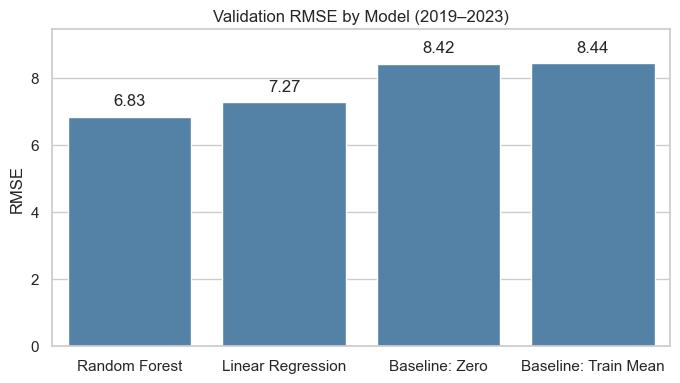

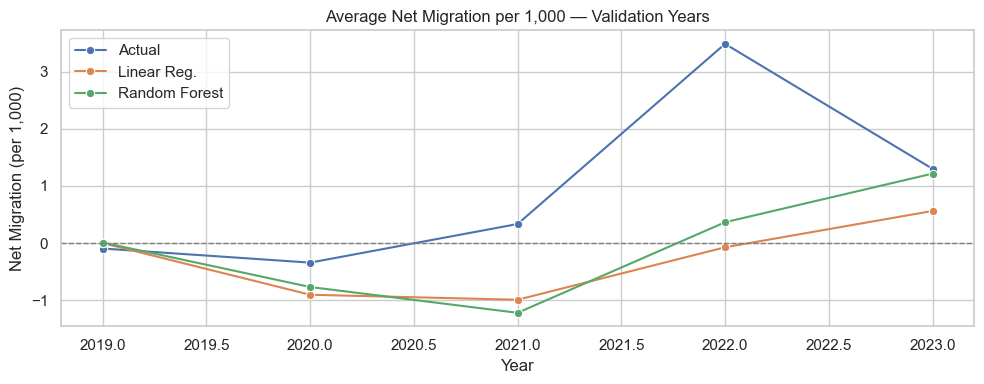

[INFO] Model evaluation completed — results summary below:


,RMSE,MAE,R2
Model,,,
Random Forest,6.833188,3.626992,0.332837
Linear Regression,7.272111,4.296913,0.244375
Baseline: Zero,8.418097,4.484606,-0.012542
Baseline: Train Mean,8.435762,4.484374,-0.016796


In [7]:
# === Evaluation ===

# --- RMSE Comparison by Model ---
plt.figure(figsize=(7, 4))
ax = sns.barplot(x=results_df.index, y=results_df["RMSE"], color="steelblue")
plt.title("Validation RMSE by Model (2019–2023)")
plt.ylabel("RMSE")
plt.xlabel("")

# Add value labels above bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=6)

# Add headroom so labels are not clipped
y_max = results_df["RMSE"].max()
plt.ylim(0, y_max + 1)

plt.tight_layout()
plt.show()

# --- Predicted vs. Actual (Year-Averaged) ---
valid_year_pred = (
    pd.DataFrame({
        "year": df_model.loc[valid_mask, "year"].values,
        "y_true": y_valid.values,
        "lr_pred": y_pred_lr,
        "rf_pred": y_pred_rf
    })
    .groupby("year", as_index=False)
    .mean()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=valid_year_pred, x="year", y="y_true", marker="o", label="Actual")
sns.lineplot(data=valid_year_pred, x="year", y="lr_pred", marker="o", label="Linear Reg.")
sns.lineplot(data=valid_year_pred, x="year", y="rf_pred", marker="o", label="Random Forest")

plt.title("Average Net Migration per 1,000 — Validation Years")
plt.ylabel("Net Migration (per 1,000)")
plt.xlabel("Year")
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.tight_layout()
plt.show()

print("[INFO] Model evaluation completed — results summary below:")
results_df

<a id="feature-importance"></a>
## 🌲 8. Feature Importance (Random Forest)

Examine the **relative influence of predictors** on model performance. Feature importance reflects how strongly each variable contributes to explaining variation in migration outcomes.

**Key drivers identified:**
- Population growth  
- HDI (Human Development Index)  
- Fertility rate  
- Income-group interaction terms  
- Trade openness ratio  

> These findings align with migration theory — linking **demographic pressure**, **development stage**, and **economic opportunity** as core determinants of population movement.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

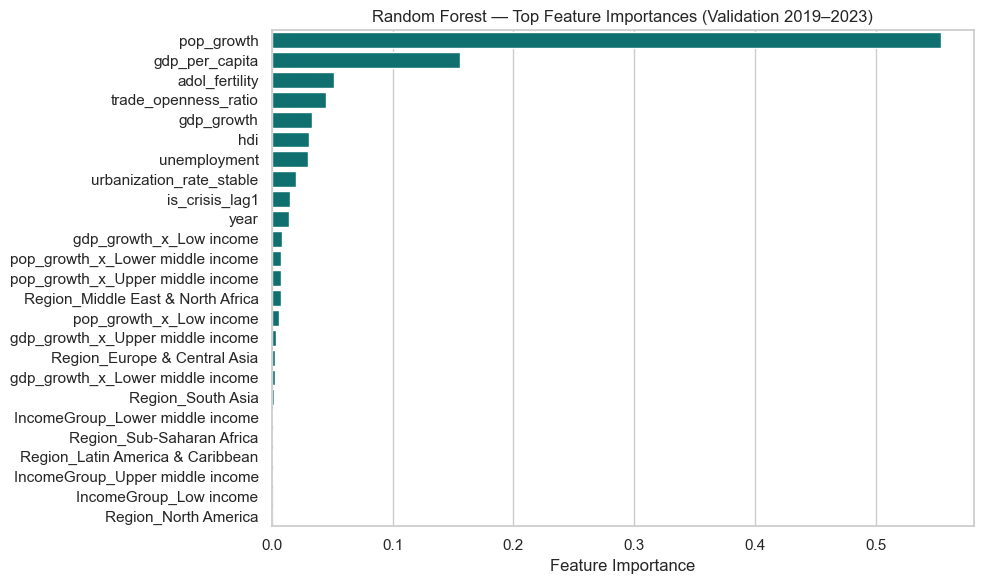

[INFO] Top 25 influential features in Random Forest model:


,importance
pop_growth,0.553718
gdp_per_capita,0.156226
adol_fertility,0.051662
trade_openness_ratio,0.044913
gdp_growth,0.033361
hdi,0.031094
unemployment,0.029709
urbanization_rate_stable,0.019753
is_crisis_lag1,0.014790
year,0.014411


In [8]:
# === Feature Importance (Random Forest) ===

# --- Compute Feature Importances ---
rf_importance = (
    pd.Series(rf.feature_importances_, index=X_train.columns)
    .sort_values(ascending=False)
)

# --- Visualize Top Features ---
imp_top = rf_importance.head(25)
plt.figure(figsize=(10, 6))
sns.barplot(x=imp_top.values, y=imp_top.index, color="teal")
plt.title("Random Forest — Top Feature Importances (Validation 2019–2023)")
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- Display Top Variables ---
print("[INFO] Top 25 influential features in Random Forest model:")
rf_importance.to_frame("importance").head(25)

<a id="error-slices"></a>
## 🧮 9. Error Slices (by Region / Income Group)

Evaluate **prediction errors across country clusters** to uncover potential model biases. Residual analysis helps identify whether performance varies systematically by geography or development level.

**Key observation:**  
Errors are typically lowest for **high-income regions** and highest for **low-income groups**, reflecting greater volatility and unmodeled crisis dynamics in those contexts.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

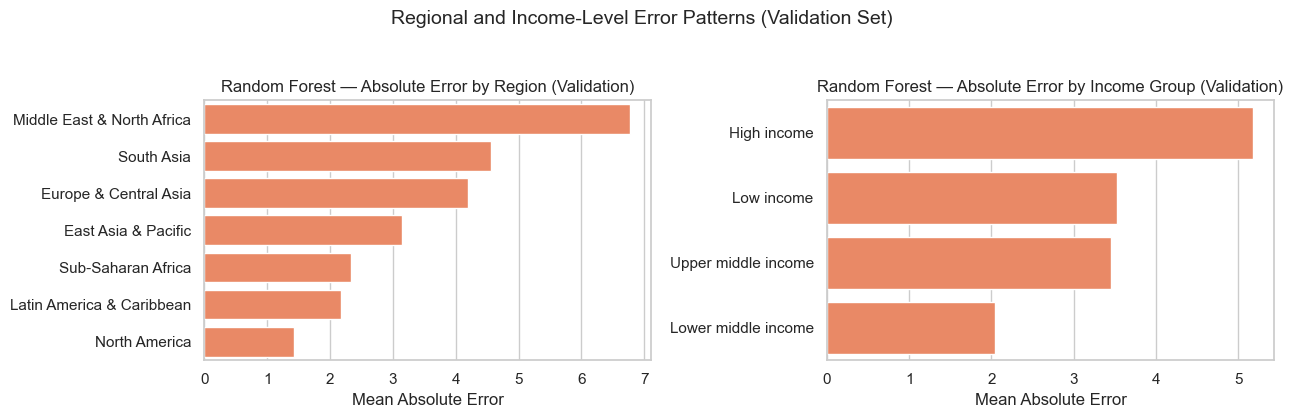

[INFO] Error slice summary — mean absolute errors by region and income group:


,Region_MAE,IncomeGroup_MAE
East Asia & Pacific,3.150230,NaN
Europe & Central Asia,4.193813,NaN
High income,NaN,5.175101
Latin America & Caribbean,2.174201,NaN
Low income,NaN,3.523900
Lower middle income,NaN,2.038796
Middle East & North Africa,6.777706,NaN
North America,1.421838,NaN
South Asia,4.567495,NaN
Sub-Saharan Africa,2.335112,NaN


In [9]:
# === Error Slices (by Region / Income Group) ===

# --- Prepare Evaluation DataFrame ---
valid_keys = df.loc[valid_mask, ["Country Name", "year", "Region", "IncomeGroup"]].reset_index(drop=True)
valid_eval = valid_keys.copy()
valid_eval["y_true"] = y_valid.values
valid_eval["rf_pred"] = y_pred_rf
valid_eval["abs_err"] = (valid_eval["y_true"] - valid_eval["rf_pred"]).abs()

# --- Compute Mean Absolute Error by Region and Income Group ---
err_region = (
    valid_eval.groupby("Region", dropna=False)["abs_err"]
    .mean()
    .sort_values(ascending=False)
)
err_income = (
    valid_eval.groupby("IncomeGroup", dropna=False)["abs_err"]
    .mean()
    .sort_values(ascending=False)
)

# --- Visualization: Regional and Income-Level Error Patterns ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.barplot(x=err_region.values, y=err_region.index, color="coral", ax=axes[0])
axes[0].set_title("Random Forest — Absolute Error by Region (Validation)", fontsize=12)
axes[0].set_xlabel("Mean Absolute Error")
axes[0].set_ylabel("")

sns.barplot(x=err_income.values, y=err_income.index, color="coral", ax=axes[1])
axes[1].set_title("Random Forest — Absolute Error by Income Group (Validation)", fontsize=12)
axes[1].set_xlabel("Mean Absolute Error")
axes[1].set_ylabel("")

plt.suptitle("Regional and Income-Level Error Patterns (Validation Set)", fontsize=14, y=1.04)
plt.tight_layout()
plt.show()

print("[INFO] Error slice summary — mean absolute errors by region and income group:")
display(pd.DataFrame({
    "Region_MAE": err_region,
    "IncomeGroup_MAE": err_income
}))

**Interpretation:**  

Model errors vary by both region and income group for different reasons.
High MAE in *Middle East & North Africa* and *South Asia* reflects structural volatility and crisis-driven migration, where socioeconomic predictors explain less variance.

In contrast, *high-income countries* show larger absolute errors mainly due to the **scale of migration flows**, not poorer model fit — their migration levels are simply much higher in magnitude.

## 💾 10. Save Artifacts

Export **trained model objects** and **feature metadata** for reproducibility and downstream explainability. The following files are saved to the `/models` directory:

- `random_forest_model.pkl` — trained Random Forest model  
- `X_columns.pkl` — feature column list used during training  

These artifacts will be loaded in **[Notebook 04: Model Interpretation and Scenario Analysis](04-model-interpretation-scenario-analysis.html)**.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [10]:
# === Save Artifacts ===
# Export trained model, feature metadata, and model-ready dataset for downstream notebooks

from pathlib import Path
import joblib
import pandas as pd

# --- Define Output Directories ---
OUT_MODELS = Path("../models")
OUT_DATA = Path("../data/processed")
OUT_MODELS.mkdir(parents=True, exist_ok=True)
OUT_DATA.mkdir(parents=True, exist_ok=True)

# --- Save Model Artifacts ---
results_df.to_csv(OUT_MODELS / "03_results_summary.csv", index=True)
rf_importance.to_csv(OUT_MODELS / "03_rf_feature_importance.csv", header=["importance"])
joblib.dump(rf, OUT_MODELS / "random_forest_model.pkl")
joblib.dump(X_cols, OUT_MODELS / "X_columns.pkl")
print("✅ Model artifacts saved to: ../models")

# --- Prepare Model-Ready Dataset (for Notebooks 04–05) ---
id_cols = ["country", "year"]
y_col = "net_migration_per_1000_capped"

# Ensure necessary columns exist
if "country" not in df_model.columns and "country" in df.columns:
    df_model["country"] = df["country"]
if "IncomeGroup" not in df_model.columns and "IncomeGroup" in df.columns:
    df_model["IncomeGroup"] = df["IncomeGroup"]

cols = [c for c in id_cols + ["IncomeGroup", y_col] + X_cols if c in df_model.columns]
model_ready = df_model[cols].copy()

# --- Clean for File Compatibility ---
model_ready = model_ready.loc[:, ~model_ready.columns.duplicated()]
model_ready.columns = model_ready.columns.str.replace(r"[ /-]", "_", regex=True)

# Convert boolean columns to small integers (Parquet compatibility)
for c in model_ready.select_dtypes(include="bool"):
    model_ready[c] = model_ready[c].astype("int8")

print(f"[INFO] Model-ready dataset shape: {model_ready.shape}")
print(f"[INFO] Total columns: {len(model_ready.columns)}")

# --- Save Final Outputs ---
model_ready.to_csv(OUT_DATA / "model_ready.csv", index=False)
try:
    model_ready.to_parquet(OUT_DATA / "model_ready.parquet", index=False, engine="fastparquet")
except Exception as e:
    print(f"⚠️ Parquet save failed ({type(e).__name__}): {e}")
else:
    print("✅ Parquet version saved successfully")

print("✅ Model-ready CSV saved to: ../data/processed/model_ready.csv")

✅ Model artifacts saved to: ../models
[INFO] Model-ready dataset shape: (5712, 28)
[INFO] Total columns: 28
✅ Parquet version saved successfully
✅ Model-ready CSV saved to: ../data/processed/model_ready.csv


## 🧾 11. Key Insights Summary

- Predictive stability is achieved through the **capped migration target** and **interpretable engineered features**.  
- **Income-tier interactions** effectively capture structural heterogeneity in migration drivers without adding excess model complexity.  
- **Nonlinear ensemble methods** (e.g., Random Forest) yield consistent but moderate improvements over linear baselines.  
- **Feature importance analysis** confirms the central role of **demographic** and **developmental** indicators — notably population growth, HDI, and fertility rate.  

> This feature-engineered modeling setup establishes a **robust, interpretable foundation**  
> for the next phase of the workflow — **[Notebook 04: Model Interpretation and Scenario Analysis](04-model-interpretation-scenario-analysis.html)**.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---